# GALAH DR4 Post Processing

This script is used to follow up the spectroscopic analysis and post-process things like binarity etc.

The code is maintained at
https://github.com/svenbuder/GALAH_DR4
and described at
https://github.com/svenbuder/galah_dr4_paper

Author(s): Sven Buder (ANU, ASTRO 3D)

History:  
220616: Created

In [1]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
    %config Completer.use_jedi = False
except:
    pass

import numpy as np
import sys
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from astropy.table import Table,join
import astropy.constants as c
import astropy.units as u
from scipy.optimize import curve_fit

In [2]:
dr60_unique = Table.read('../observations/dr6.0_230101_unique_ids.fits')
dr60_unique['date'] = np.array([str(x)[:6] for x in dr60_unique['sobject_id']])
unique_dates = np.unique(dr60_unique['date'])

# Post process each date

In [3]:
if sys.argv[1] != '-f':
    date = sys.argv[1]
    if len(sys.argv) > 2:
        if sys.argv[2] == 'all':
            use_setup = 'all'
        elif sys.argv[2] == 'single':
            use_setup = 'single'
        elif sys.argv[2] == 'binary':
            use_setup = 'binary'
        elif sys.argv[2] == 'coadds':
            use_setup = 'coadds'
        elif sys.argv[2] == 'plxcom':
            use_setup = 'plxcom'
    else:
        use_setup = 'plxcom'
else:

#     date = '131220' # NGC_104_47Tuc
#     date = '140111' # NGC_104_47Tuc
#     date = '140114' # NGC_288
#     date = '140115' # NGC_1851
#     date = '140303' # NGC_5139_oCen
    date = '140305' # NGC_5139_oCen
#     date = '140307' # NGC_5139_oCen
#     date = '140314' # NGC_5139_oCen
#     date = '140713' # NGC_6362
#     date = '140806' # NGC_362
#     date = '140808' # NGC_104_47Tuc
#     date = '140811' # NGC_104_47Tuc
#     date = '140823' # NGC_362
#     date = '140824' # NGC_104_47Tuc
#     date = '150824' # NGC_6362
#     date = '150901' # NGC_7099_M_30
#     date = '160326' # NGC_5986
#     date = '160327' # NGC_6397
#     date = '160419' # NGC_5139_oCen
#     date = '160424' # NGC_6584
#     date = '160520' # NGC_6723
#     date = '170614' # NGC_4590_M_68
#     date = '170905' # NGC_6541
#     date = '180603' # E_3
#     date = '200519' # BH_140
#     date = '210607' # NGC_6144
#     date = '210802' # NGC_6121_M_4
#     date = '210803' # NGC_6121_M_4
#     date = '220518' # NGC_6121_M_4
#     date = '220522' # NGC_6121_M_4
#     date = '220622' # NGC_6121_M_4
#     date = '220807' # NGC_7089_M_2

    use_setup = 'plxcom'

print('Post-Processing '+date+' with setup '+use_setup)

Post-Processing 140305 with setup plxcom


In [4]:
dr60_unique = dr60_unique[dr60_unique['date'] == date]

In [5]:
dr60_all = Table.read('../observations/dr6.0_230101.fits')
dr60_all.remove_columns(['tmass_id','date'])
if 'source_id' in dr60_unique.keys():
    dr60_all.remove_column('source_id')

initial_values = Table.read('../spectrum_analysis/galah_dr4_initial_parameters_230101.fits')

In [6]:
dr60 = join(dr60_unique,dr60_all,keys='sobject_id')
print('Nr Entries: '+str(len(dr60['date'])))

Nr Entries: 650


In [7]:
masks = Table.read('../spectrum_analysis/spectrum_masks/solar_spectrum_mask.fits')

In [8]:
# flag_sp_dictionary = dict()

# flag_sp_dictionary['emission']       = [1,'Emission in Halpha/Hbeta detected']
# flag_sp_dictionary['ccd_missing']    = [2,'Not all 4 CCDs available']

# flag_sp_dictionary['is_sb1']         = [4,'Spectroscopic Binary SB1 (RV changes beyond 2sigma)']
# flag_sp_dictionary['is_sb2']         = [8,'Spectroscopic Binary SB2 (Double line splitting)']
# flag_sp_dictionary['chi2_3sigma']    = [16,'Chi2 unusually low/high by 3 sigma']
# flag_sp_dictionary['vsini_warn']     = [32,'Broadening (vsini) warning']
# flag_sp_dictionary['vmic_warn']      = [64,'Microturbulence (vmic) warning']

# flag_sp_dictionary['sb_triple_warn'] = [128,'Double line splitting detected (SB2)']
# flag_sp_dictionary['teff_warn']      = [256,'Temperature (teff) warning']
# flag_sp_dictionary['logg_warn']      = [512,'Gravity (logg) warning']
# flag_sp_dictionary['fe_h_warn']      = [1024,'[Fe/H] (fe_h) warning']
# flag_sp_dictionary['snr_warn']       = [2048,'Signal-to-noise indicates spectra not reliable']
# flag_sp_dictionary['not_converged']  = [4096,'Not converged within 4 iterations']
# flag_sp_dictionary['no_model']       = [8192,'Extrapolating spectrum model']
# flag_sp_dictionary['no_results']     = [16384,'No spectroscopic analysis results available']

# a_file = open("final_flag_sp_dictionary.pkl", "wb")
# pickle.dump(flag_sp_dictionary,a_file)
# a_file.close()

a_file = open("final_flag_sp_dictionary.pkl", "rb")
flag_sp_dictionary = pickle.load(a_file)
a_file.close()

In [9]:
def apply_final_flag_sp(results,spectra,final_table_row,has_results,emission_info):
    intermediate_flag_sp = np.int32(0)
        
    for reason in flag_sp_dictionary.keys():
        
        # Raise flag for 'no_results'
        if reason == 'no_results':
            if not has_results:
                intermediate_flag_sp += flag_sp_dictionary['no_results'][0]
                
        if has_results:
            
            # Raise flag for 'chi2_3sigma':
            # If the chi2_sp is more than 3 sigma above or below the expected value of median=0.82
            if reason == 'chi2_3sigma':
                if (final_table_row['chi2_sp'] < 0.57) | (final_table_row['chi2_sp'] > 1.4):
                    intermediate_flag_sp += flag_sp_dictionary['chi2_3sigma'][0]

            if reason == 'snr_warn':
                if np.any([final_table_row['snr_px_ccd'+str(ccd)] < 10.01 for ccd in [1,2,3,4]]) | (np.percentile(spectra['sob'],q=25) < 0):
                    intermediate_flag_sp += flag_sp_dictionary['snr_warn'][0]

                    
            # Raise flag for 'is_sb1':
            # If we have a significant and repeated detection of a velocity peak in the residual of sob-smod
            if reason == 'is_sb1':
                if final_table_row['fit_global_rv'] == False:
                    intermediate_flag_sp += flag_sp_dictionary['is_sb1'][0]
                    
            # Raise flag for 'is_sb2':
            # If we have a significant and repeated detection of a velocity peak in the residual of sob-smod
            if reason == 'is_sb2':
                if np.isfinite(final_table_row['sb2_rv_16']):
                    intermediate_flag_sp += flag_sp_dictionary['is_sb2'][0]

            # Raise flag for 'vsini_warn':
            if reason == 'vsini_warn':
                if (final_table_row['vsini'] < 0) | (final_table_row['vsini'] > 25):
                    intermediate_flag_sp += flag_sp_dictionary['vsini_warn'][0]

            # Raise flag for 'vmic_warn':
            if reason == 'vmic_warn':
                if final_table_row['vmic'] < np.max([0.5,0.5 + 0.5*(final_table_row['teff']-6000.)/1000.]):
                    intermediate_flag_sp += flag_sp_dictionary['vmic_warn'][0]

            # Raise flag for 'emission':
            if reason == 'emission':
                if emission_info['any_emission']:
                    intermediate_flag_sp += flag_sp_dictionary['emission'][0]

            if reason == 'not_converged':
                if((results['flag_sp_fit'][0] & 4) == 4):
                    intermediate_flag_sp += flag_sp_dictionary['not_converged'][0]

            if reason == 'ccd_missing':
                if((results['flag_sp_fit'][0] & 8) == 8):
                    intermediate_flag_sp += flag_sp_dictionary['ccd_missing'][0]

            if reason == 'no_model':
                if ((results['flag_sp_fit'][0] & 1) == 1) | ((results['flag_sp_fit'][0] & 2) == 2):
                    intermediate_flag_sp += flag_sp_dictionary['no_model'][0]

    return(intermediate_flag_sp)

In [10]:
# # TEST CASES:

# single_result = Table.read('../analysis_products/131216/131216002601003/131216002601003_single_fit_results.fits')
# binary_result = Table.read('../analysis_products/131216/131216001101026/131216001101026_binary_fit_results.fits')
# coadds_result  = Table.read('../analysis_products/131216/131216002602003/131216002602003_coadds_fit_results.fits')

# for setup,result in zip(['single','binary','coadds'],[single_result, binary_result, coadds_result]):

#     final_table = Table()

#     # Same for all:
#     for label in ['sobject_id','tmass_id','gaiadr3_source_id','model_name','closest_model','closest_model']:
        
#         if label == 'gaiadr3_source_id':
#             final_table[label] = result['gaia_edr3_source_id']
#         else:
#             if (label in ['model_name','closest_model'])  & (setup == 'binary'):
#                 final_table[label] = ' teff_logg_fe_h '
#             else:
#                 final_table[label] = result[label]
            
#     print(setup)
#     for label in ['flag_sp_fit']:
#         if setup in ['single','coadds']:
#             final_table[label] = result[label]
#         else:
#             final_table[label] = result['flag_sp']
            
#     if setup == 'binary':
#         # Make sure the more important component (flux contribution >= 50%) is always listed first
#         if result['f_contr'] >= 0.5:
#             comp_1 = '1'
#             comp_2 = '2'
#         else:
#             # If the 2nd component was reported first in the results, switch them
#             result['f_contr'] = 1 - result['f_contr']
#             comp_1 = '2'
#             comp_2 = '1'
            
#     for label in ['flux_contr']:
#         if setup in ['single','coadds']:
#             final_table[label] = np.float32(1.0)
#             final_table['e_'+label] = np.float32(np.NaN)
#         else:
#             final_table[label] = result['f_contr']
#             final_table['e_'+label] = result['cov_e_f_contr']

#     for label in ['rv']:
#         if setup in ['single','coadds']:
#             final_table['rv_comp_1'] = result['rv_gauss']
#             final_table['e_rv_comp_1'] = result['e_rv_gauss']
#             try:
#                 final_table['rv_comp_1_h'] = result['rv_peak_1_h']
#                 final_table['rv_comp_1_p'] = result['rv_peak_1_p']
#                 final_table['rv_comp_2']   = result['rv_peak_2']
#                 final_table['e_rv_comp_2'] = np.float32(np.NaN)
#                 final_table['rv_comp_2_h'] = result['rv_peak_2_h']
#                 final_table['rv_comp_2_p'] = result['rv_peak_2_p']
#                 final_table['rv_comp_nr']  = result['rv_peak_nr']
#             except:
#                 final_table['rv_comp_nr']  = np.int(-1)
#                 final_table['rv_comp_1_h'] = np.float32(np.NaN)
#                 final_table['rv_comp_1_p'] = np.float32(np.NaN)
#                 final_table['rv_comp_2']   = np.float32(np.NaN)
#                 final_table['e_rv_comp_2'] = np.float32(np.NaN)
#                 final_table['rv_comp_2_h'] = np.float32(np.NaN)
#                 final_table['rv_comp_2_p'] = np.float32(np.NaN)
#         else:
#             final_table['rv_comp_1'] = result['rv_'+comp_1]
#             final_table['e_rv_comp_1'] = result['cov_e_rv_'+comp_1]
#             final_table['rv_comp_1_h'] = np.float32(np.NaN)
#             final_table['rv_comp_1_p'] = np.float32(np.NaN)
#             final_table['rv_comp_2'] = result['rv_'+comp_1]
#             final_table['e_rv_comp_2'] = result['cov_e_rv_'+comp_1]
#             final_table['rv_comp_2_h'] = np.float32(np.NaN)
#             final_table['rv_comp_2_p'] = np.float32(np.NaN)
#             final_table['rv_comp_nr']  = np.int(2)

#     for label in ['teff','logg','fe_h','vmic','vsini']:
#         if setup in ['single','coadds']:
#             final_table[label+'_comp_1'] = result[label]
#             final_table['e_'+label+'_comp_1'] = result['cov_e_'+label]
#             final_table[label+'_comp_2'] = np.float32(np.NaN)
#             final_table['e_'+label+'_comp_2'] = np.float32(np.NaN)
#         else:
#             try:
#                 final_table[label+'_comp_1'] = result[label+'_'+comp_1]
#                 final_table['e_'+label+'_comp_1'] = result['cov_e_'+label+'_'+comp_1]
#                 final_table[label+'_comp_2'] = result[label+'_'+comp_2]
#                 final_table['e_'+label+'_comp_2'] = result['cov_e_'+label+'_'+comp_2]
#             except:
#                 final_table[label+'_comp_1'] = result[label]
#                 final_table['e_'+label+'_comp_1'] = result['cov_e_'+label]
#                 final_table[label+'_comp_2'] = result[label]
#                 final_table['e_'+label+'_comp_2'] = result['cov_e_'+label]

#     for element in [
#         'Li','C','N','O',
#         'Na','Mg','Al','Si',
#         'K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn',
#         'Rb','Sr','Y','Zr','Mo','Ru',
#         'Ba','La','Ce','Nd','Sm','Eu'
#     ]:
#         if setup in ['single','coadds']:
#             final_table[element.lower()+'_fe'] = result[element.lower()+'_fe']
#             final_table['e_'+element.lower()+'_fe'] = result['cov_e_'+element.lower()+'_fe']
#             final_table['flag_'+element.lower()+'_fe'] = result['flag_'+element.lower()+'_fe']
#         else:
#             final_table[element.lower()+'_fe'] = np.float32(np.NaN)
#             final_table['e_'+element.lower()+'_fe'] = np.float32(np.NaN)
#             final_table['flag_'+element.lower()+'_fe'] = np.int(-1)

In [11]:
def create_final_dr40_table(setup):
    
    empty_final_dr40_table = Table()
    table_length = len(dr60['sobject_id'])
    
    # Identifiers
    empty_final_dr40_table['sobject_id'] = np.array(dr60['sobject_id'], dtype=np.int64)
    empty_final_dr40_table['tmass_id'] = np.array(dr60['tmass_id'], dtype=str)
    empty_final_dr40_table['gaiadr3_source_id'] = np.array(dr60['source_id'], dtype=np.int64)

    # Program/Survey information
    empty_final_dr40_table['survey_name'] = np.array(dr60['survey_name'], dtype=str)
    empty_final_dr40_table['field_id'] = np.array(dr60['field_id'], dtype=np.int32)

    empty_final_dr40_table['setup'] = np.array([setup for x in range(table_length)], dtype=str)
   
    empty_final_dr40_table['mjd'] = np.array(dr60['mjd'], dtype=np.float32)
    
    # Positions
    empty_final_dr40_table['ra'] = np.array(dr60['ra'], dtype=np.float64)
    empty_final_dr40_table['dec'] = np.array(dr60['dec'], dtype=np.float64)

    empty_final_dr40_table['best_spec4star'] = np.zeros(table_length, dtype=bool)
        
    # Major Spectroscopic Results
    empty_final_dr40_table['flag_sp'] = -np.ones(table_length, dtype=np.int32)
    empty_final_dr40_table['flag_sp_fit'] = -np.ones(table_length, dtype=np.int32)
    empty_final_dr40_table['opt_loop'] = -np.ones(table_length, dtype=np.int32)
    if setup in ['single','binary','plxcom']:
        empty_final_dr40_table['flag_red'] = np.array(dr60['reduction_flags'], dtype=np.int32)
    else:
        empty_final_dr40_table['flag_red'] = -np.ones(table_length, dtype=np.int32)
        
    # Additional information from spectrum_analysis
    for ccd in [1,2,3,4]:
        empty_final_dr40_table['snr_px_ccd'+str(ccd)] = dr60['snr'][:,ccd-1]

    for label in ['chi2_sp']:
        empty_final_dr40_table[label] = np.zeros(table_length, dtype=np.float32); empty_final_dr40_table[label][:] = np.NaN
    for label in ['px_used_perc']:
        empty_final_dr40_table[label] = np.zeros(table_length, dtype=np.int)
    for label in ['model_name']:
        empty_final_dr40_table[label] = np.array([' teff_logg_fe_h ' for x in range(table_length)])
    for label in ['closest_model']:
        empty_final_dr40_table[label] = np.array([' teff_logg_fe_h ' for x in range(table_length)])
    for label in ['comp_time']:
        empty_final_dr40_table[label] = np.zeros(table_length, dtype=np.float32); empty_final_dr40_table[label][:] = np.NaN

    for label in ['flux_contr']:
        empty_final_dr40_table[label] = np.ones(table_length, dtype=np.float32)
        empty_final_dr40_table['e_'+label] = np.zeros(table_length, dtype=np.float32); empty_final_dr40_table['e_'+label][:] = np.NaN
        
    # RV results
    for label in [
        'fit_global_rv',
        'rv_comp_nr',
        'rv_comp_1',
        'e_rv_comp_1',
        'rv_comp_1_h',
        'rv_comp_1_p',
        'rv_comp_2',
        'e_rv_comp_2',
        'rv_comp_2_h',
        'rv_comp_2_p'
    ]:
        if label in ['rv_comp_nr']:
            empty_final_dr40_table[label] = np.ones(table_length, dtype=np.int)
        if label in ['fit_global_rv']:
            empty_final_dr40_table[label] = np.ones(table_length, dtype=np.bool)
        else:
            empty_final_dr40_table[label] = np.zeros(table_length, dtype=np.float32); empty_final_dr40_table[label][:] = np.NaN

    for label in ['rv_gaia_dr3','e_rv_gaia_dr3']:
        empty_final_dr40_table[label] = np.zeros(table_length, dtype=np.float32); empty_final_dr40_table[label][:] = np.NaN

    empty_final_dr40_table['v_bary_eff'] = np.array(dr60['v_bary_eff'], dtype=np.float64)

    for label in ['teff','logg','fe_h','vmic','vsini']:
        empty_final_dr40_table[label] = np.zeros(table_length, dtype=np.float32); empty_final_dr40_table[label][:] = np.NaN
        empty_final_dr40_table['e_'+label] = np.zeros(table_length, dtype=np.float32); empty_final_dr40_table['e_'+label][:] = np.NaN
        if label == 'fe_h':
            empty_final_dr40_table['flag_'+label] = -np.ones(table_length, dtype=np.int32)
    for label in ['teff','logg','fe_h','vmic','vsini']:
        empty_final_dr40_table[label+'_comp_2'] = np.zeros(table_length, dtype=np.float32); empty_final_dr40_table[label+'_comp_2'][:] = np.NaN
        empty_final_dr40_table['e_'+label+'_comp_2'] = np.zeros(table_length, dtype=np.float32); empty_final_dr40_table['e_'+label+'_comp_2'][:] = np.NaN
        if label == 'fe_h':
            empty_final_dr40_table['flag_'+label+'_comp_2'] = -np.ones(table_length, dtype=np.int32)


    # Elements
    for element in [
                'Li','C','N','O',
                'Na','Mg','Al','Si',
                'K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn',
                'Rb','Sr','Y','Zr','Mo','Ru',
                'Ba','La','Ce','Nd','Sm','Eu'
        ]:
        empty_final_dr40_table[element.lower()+'_fe'] = np.zeros(table_length, dtype=np.float32); empty_final_dr40_table[element.lower()+'_fe'][:] = np.NaN
        empty_final_dr40_table['e_'+element.lower()+'_fe'] = np.zeros(table_length, dtype=np.float32); empty_final_dr40_table['e_'+element.lower()+'_fe'][:] = np.NaN
        empty_final_dr40_table['flag_'+element.lower()+'_fe'] = -np.ones(table_length, dtype=np.int32)
        
    # plx information
    for label in [
        'mass','age','bc_ks','a_ks','lbol','r_med','r_lo','r_hi'
    ]:
        empty_final_dr40_table[label] = np.zeros(table_length, dtype=np.float32); empty_final_dr40_table[label][:] = np.NaN
        
    # Post processed analysis
    for label in [
        'sb2_rv_16','sb2_rv_50','sb2_rv_84',
        'ew_h_beta','ew_h_alpha',
        'ew_k_is', 'sigma_k_is', 'rv_k_is'
        ]:
        empty_final_dr40_table[label] = np.zeros(table_length, dtype=np.float32); empty_final_dr40_table[label][:] = np.NaN
    for line in [5780.59,5797.19,6613.66]:
        for label in ['ew_dib'+str(int(line)),'sigma_dib'+str(int(line)),'rv_dib'+str(int(line))]:
            empty_final_dr40_table[label] = np.zeros(table_length, dtype=np.float32); empty_final_dr40_table[label][:] = np.NaN

    return(empty_final_dr40_table)

In [12]:
# We will assess line-splitting due to binarity with a few spectral lines
spectral_lines_to_assess = [
    4861.3230, # Hbeta
    6562.7970, # Halpha
    7771.9440, # O triplet
    7774.1660, # O triplet
    7775.3880, # O triplet
    7691.5500, # Mg line
    # Note that we do not use the K line here, because it was wrongly detecting interstellar as binary signatures
    4890.7551, # Fe line
    4891.4921, # Fe line
    6643.6303, # Ni line
]

In [13]:
def identify_possible_RV_shifts(
    spectra,
    results,
    minimum_significance_in_sigma = 5,
    search_window_width_in_kms = 500,
    search_window_center_in_kms = 0,
    search_peak_width_in_kms = 50,
    final = False,
    debug = False,
    ):
        
    possible_line_splitting_peaks = []
    
    # We have to make sure that the regions that are always masked (never fitted) are actually not used for estimating binarity
    not_modelled = np.any(np.array([((spectra['wave'] >= mask_beginning) & (spectra['wave'] <= mask_end)) for (mask_beginning, mask_end) in zip(masks['mask_begin'],masks['mask_end'])]),axis=0)
    
    smod_for_binarity_test = np.array(spectra['smod'])
    smod_for_binarity_test[not_modelled] = spectra['sob'][not_modelled]
    
    for line in spectral_lines_to_assess:
        wave_km_s = ((spectra['wave']/line - 1)*c.c).to(u.km/u.s).value
        within_rv_shift_km_s = np.abs(wave_km_s - search_window_center_in_kms) < 0.5*search_window_width_in_kms
        

        # We will work with the difference of observed and synthetic spectra
        # To avoid low SNR to introduce issues, we will only allow differences above 
        # certain thresholds to be used
        adjusted_flux_difference = (spectra['sob'][within_rv_shift_km_s] - smod_for_binarity_test[within_rv_shift_km_s])
        adjusted_flux_difference[adjusted_flux_difference>-0.05] = 0.00
        
        # Let's interpolate the difference onto an equidistance velocity array
        equidistant_velocity = np.arange(-0.5*search_window_width_in_kms+search_window_center_in_kms,0.5*search_window_width_in_kms+search_window_center_in_kms+0.1,0.5)
        equidistant_flux_difference = np.interp(equidistant_velocity,wave_km_s[within_rv_shift_km_s],adjusted_flux_difference/spectra['uob'][within_rv_shift_km_s])
        
        if debug:
            
            f, gs = plt.subplots(1,2,figsize=(15,5))
            
            # Left panel: spectrum in AA in a left panel
            # Right panel: flux difference (relative to noise) in km/s, including peaks that were identified
            
            ax = gs[0]
            ax.set_xlabel(r'Shift from '+str(line)+'$\,\mathrm{\AA}~/~\mathrm{km\,s^{-1}}$')
            ax.set_ylabel('Flux / norm.')

            ax.plot(
                wave_km_s[within_rv_shift_km_s],
                spectra['sob'][within_rv_shift_km_s],
                c = 'k', label = 'Observation', lw = 1
            )
            ax.plot(
                wave_km_s[within_rv_shift_km_s],
                spectra['smod'][within_rv_shift_km_s],
                c = 'r', label='Single Star Fit', lw = 1
            )
                            
            ax = gs[1]
            ax.set_xlabel(r'Shift from '+str(line)+'$\,\mathrm{\AA}~/~\mathrm{km\,s^{-1}}$')
            ax.set_ylabel(r'$\Delta$Flux / $\sigma$Flux')
            ax.plot(
                equidistant_velocity,
                equidistant_flux_difference,
                c = 'k', label='Residual', lw = 1
            )
        
        # We will henceforth only consider flux difference above a specified sigma
        equidistant_flux_difference[equidistant_flux_difference > -minimum_significance_in_sigma] = 0
        equidistant_flux_difference[equidistant_flux_difference > -minimum_significance_in_sigma] = 0
        
        # Let's iteratively go through the spectrum and find peaks
        # everytime, when we find a peak, we add it to *possible_line_splitting_peaks*
        # and then set the values within the search window (e.g. +- 25km/s) of it to 0, until we cannot find any new peak
        # For Halpha and Hbeta, we only do that once, because we expect the lines to cover more than the other lines

        equidistant_flux_difference_to_search = equidistant_flux_difference
        # To avoid badly fit lines (causing a peak at 0 km/s) to throw us off the path,
        # We set the difference within 25 km/s (most stars line broadening should be below this threshold) to 0
        equidistant_flux_difference_to_search[np.abs(equidistant_velocity) < 0.5*search_peak_width_in_kms] = 0
        
        # For Halpha and Hbeta, we actually go even broader, because we know their line cores and not fit well
        if (not final) & (line in [4861.3230,6562.7970]):
            equidistant_flux_difference_to_search[np.abs(equidistant_velocity) < 1*search_peak_width_in_kms] = 0
        
        while np.min(equidistant_flux_difference_to_search) < -minimum_significance_in_sigma:
            
            # find a new modus/peak
            new_peak_index = np.argmin(equidistant_flux_difference_to_search)
            
            # add it to possible_line_splitting_peaks
            possible_line_splitting_peaks.append(equidistant_velocity[np.argmin(equidistant_flux_difference)])
                        
            if debug:
                ax.plot(
                    equidistant_velocity,
                    equidistant_flux_difference_to_search,
                    label='_nolegend_', lw = 1
                )
            
            # set flux to search in to 0 within search window of new peak
            if line in [4861.3230,6562.7970]:
                indices_within_search_window = np.abs(equidistant_velocity - equidistant_velocity[np.argmin(equidistant_flux_difference)]) < 1*search_peak_width_in_kms
                equidistant_flux_difference_to_search[indices_within_search_window] = 0
            else:
                indices_within_search_window = np.abs(equidistant_velocity - equidistant_velocity[np.argmin(equidistant_flux_difference)]) < 0.5*search_peak_width_in_kms
                equidistant_flux_difference_to_search[indices_within_search_window] = 0

    if len(possible_line_splitting_peaks) >= 4:
        hist = np.histogram(possible_line_splitting_peaks, bins=np.arange(-0.5*search_window_width_in_kms+search_window_center_in_kms,0.5*search_window_width_in_kms+search_window_center_in_kms+0.1,20))
        if debug:
            plt.figure()
            plt.hist(possible_line_splitting_peaks, bins=np.arange(-0.5*search_window_width_in_kms+search_window_center_in_kms,0.5*search_window_width_in_kms+search_window_center_in_kms+0.1,20))
            print(np.max(hist[0]))
            
        # Now let's decide which value to give back
        if not final:
            # Give back the mode
            return([hist[1][np.argmax(hist[0])]])
        else:
            # Actually calculate percentiles
            return(np.percentile(possible_line_splitting_peaks, q=[16,50,84]))
    else:
        return([np.NaN])

In [14]:
def assess_sb2_binarity(spectra,results,debug=False):
    """
    Testing if the star is a spectroscopic binary with double line splitting
    """
    sb2_rv_16 = np.NaN; sb2_rv_50 = np.NaN; sb2_rv_84 = np.NaN

    # Let's first apply a broad search for the most narrow peak
    most_common_peak = identify_possible_RV_shifts(
        spectra = spectra,
        results = results,
        minimum_significance_in_sigma = 5,
        search_window_width_in_kms = 500,
        search_window_center_in_kms = 0,
        search_peak_width_in_kms = 50,
        final = False,
        debug = debug
    )
    
    if np.isfinite(most_common_peak[0]):

        if debug:
            print('Found common peak at ', most_common_peak[0])
        
        # Now off to a narrower analysis of the most common peak
        binary_rv_shift_percentiles = identify_possible_RV_shifts(
            spectra = spectra,
            results = results,
            minimum_significance_in_sigma = 5,
            search_window_width_in_kms = 50,
            search_window_center_in_kms = most_common_peak[0],
            search_peak_width_in_kms = 50,
            final = True,
            debug = debug
        )
        if len(binary_rv_shift_percentiles) == 3:
            p16,p50,p84 = binary_rv_shift_percentiles
            if debug:
                print('Returning 16/50/84th percentiles')
                print('median +- sigma:')
                print(r'$'+"{:.1f}".format(p50)+r'_{'+"{:.1f}".format(p50-p16)+r'}^{'+"{:.1f}".format(p84-p50)+'}~/~\mathrm{km\,s^{-1}}$')
            return(p16,p50,p84)
        else:
            return([np.NaN,most_common_peak[0],np.NaN])
            #print('No Peaks above required significance found for narrower search')
    else:
        return([np.NaN,np.NaN,np.NaN])
        #print('No Peaks above required significance found')
    
    return(sb2_rv_16,sb2_rv_50,sb2_rv_84)

In [15]:
def assess_binarity(spectra,results,debug=False):
    """
    Based on the observed and synthetic spectra, this script analysis the residuals to identify common peaks
    """
    
    # First let's test if we have a spectroscopic binary type 2 (double-lined spectroscopic binary)
    sb2_rv_16,sb2_rv_50,sb2_rv_84 = assess_sb2_binarity(spectra,results,debug)

    return(sb2_rv_16,sb2_rv_50,sb2_rv_84)

In [16]:
def assess_emission(spectra, debug=False):
    """
    Examples sobject_ids:
    131216001101315
    """

    emission_indicators = dict()
    emission_indicators['ew_h_beta'] = 4861.3230
    emission_indicators['ew_h_alpha'] = 6562.7970   
    
    emission_info = dict()
    
    any_indicator_in_emission = 0
    
    if debug:
        f, gs = plt.subplots(1,2,figsize=(7,3))

    for index, line_name in enumerate(emission_indicators.keys()):
        
        line = emission_indicators[line_name]
        
        # Let's first test the criterium if the cores of the Balmer lines are in absorption
        line_core = in_wavelength_bin = np.abs(spectra['wave'] - line) < 0.5
        # now test if the observed flux of the line core is above the continuum flux of 1:
        if np.median(spectra['sob'][line_core]) > 1:
            any_indicator_in_emission = 1
            wavelength_window = 5.0
        else:
            if line_name == 'ew_h_alpha':
                wavelength_window = 1.25
            if line_name == 'ew_h_beta':
                wavelength_window = 0.75

        in_wavelength_bin = np.abs(spectra['wave'] - line) < wavelength_window

        equivalent_width = np.trapz(spectra['smod'][in_wavelength_bin] - spectra['sob'][in_wavelength_bin],x=spectra['wave'][in_wavelength_bin])
        emission_info[line_name] = np.float32(equivalent_width)

        if debug:
            ax = gs[index]
            ax.set_title(line_name)
            ax.plot(
                spectra['wave'][in_wavelength_bin],
                spectra['sob'][in_wavelength_bin],
                label = 'sob'
            )
            ax.plot(
                spectra['wave'][in_wavelength_bin],
                spectra['smod'][in_wavelength_bin],
                label = 'smod'
            )
            ax.plot(
                spectra['wave'][in_wavelength_bin],
                spectra['smod'][in_wavelength_bin] - spectra['sob'][in_wavelength_bin],
                label = 'smod-sob'
            )
            ax.legend()
    if debug:
        plt.show()
        plt.close()
    
    if any_indicator_in_emission:
        emission_info['any_emission'] = True
    else:
        emission_info['any_emission'] = False
        
    return(emission_info)

In [17]:
def assess_interstellar_k_absorption(spectra,debug=True):

    around_k_line = np.abs(spectra['wave'] - 7698.9643) < 5
    
    if debug:
        plt.figure(figsize=(15,5))
        plt.plot(
            spectra['wave'][around_k_line],
            spectra['sob'][around_k_line],
            c='k'
        )
        plt.plot(
            spectra['wave'][around_k_line],
            spectra['smod'][around_k_line],
            c='C0'
        )

    def gauss_func(x, a, x0, sigma):
        return -np.abs(a)*np.exp(-(x-x0)**2/(2*sigma**2))

    # Executing curve_fit on noisy data
    popt, pcov = curve_fit(
        gauss_func,
        xdata = spectra['wave'][around_k_line],
        ydata = spectra['sob'][around_k_line]-spectra['smod'][around_k_line],
        p0 = [
            1,
            spectra['wave'][around_k_line][np.argmin(spectra['sob'][around_k_line]-spectra['smod'][around_k_line])],
            0.2],
        bounds = ((0,spectra['wave'][around_k_line][0],0.05),(100,spectra['wave'][around_k_line][-1],5))
    )
    
    if debug:
        plt.plot(
            spectra['wave'][around_k_line],
            spectra['smod'][around_k_line] + gauss_func(spectra['wave'][around_k_line], *popt),
            c = 'C1', ls='dashed'
        )
        plt.axvline(popt[1])
        plt.axvline(spectra['wave'][around_k_line][np.argmin(spectra['sob'][around_k_line]-spectra['smod'][around_k_line])])
        plt.ylim(-0.1,1.2)
        plt.show()
        plt.close()

    if popt[2] < 0.1:
        return(np.NaN, np.NaN, np.NaN)            
    else:
        return(
            np.float32(np.abs(popt[0] * popt[2] * np.sqrt(2*np.pi))),
            np.float32(np.abs(popt[2])),
            np.float32(((popt[1] - 7698.9643)/7698.9643*c.c).to(u.km/u.s).value)
        )

In [18]:
def assess_dib_absorption(spectra, wavelength = 5780, debug=True):
    """
    Based on results from Vogrinčič et al. (2022, in prep.)
    
    4726.40 ± 0.07 # 46
    4762.57 ± 0.06 # 60
    4855.25 ± 0.12 # 59
    4859.89 ± 0.01 # 59
    5705.21 ± 0.16 # 49
    5747.62 ± 0.35 # 55
    5780.59 ± 0.01 # 284
    5784.78 ± 0.03 # 51
    5797.19 ± 0.03 # 110
    6496.67 ± 0.20 # 53
    6530.17 ± 0.24 # 51
    6589.97 ± 0.01 # 50
    6613.66 ± 0.01 # 130
    """
    
    around_dib_line = np.abs(spectra['wave'] - wavelength) < 5
    
    if debug:
        plt.figure(figsize=(15,5))
        plt.plot(
            spectra['wave'][around_dib_line],
            spectra['sob'][around_dib_line],
            c='k'
        )
        plt.plot(
            spectra['wave'][around_dib_line],
            spectra['smod'][around_dib_line],
            c='C0'
        )

    def gauss_func(x, a, x0, sigma):
        return -np.abs(a)*np.exp(-(x-x0)**2/(2*sigma**2))

    # Executing curve_fit on noisy data
    popt, pcov = curve_fit(
        gauss_func,
        xdata = spectra['wave'][around_dib_line],
        ydata = spectra['sob'][around_dib_line]-spectra['smod'][around_dib_line],
        p0 = [1,wavelength,0.4],
        bounds = ((0,spectra['wave'][around_dib_line][0],0.05),(100,spectra['wave'][around_dib_line][-1],5))
    )

    if debug:
        plt.plot(
            spectra['wave'][around_dib_line],
            spectra['smod'][around_dib_line] + gauss_func(spectra['wave'][around_dib_line], *popt),
            c = 'C1', ls='dashed'
        )
        plt.ylim(-0.1,1.2)
        if popt[2] > 0.1:
            plt.show()
            print(popt)
        plt.close()
        
    if popt[2] < 0.1:
        return(np.NaN, np.NaN, np.NaN)
    else:
        return(
            np.float32(np.abs(popt[0] * popt[2] * np.sqrt(2*np.pi))),
            np.float32(np.abs(popt[2])),
            np.float32(((popt[1] - wavelength)/wavelength*c.c).to(u.km/u.s).value)
        )

In [19]:
# Solar Abundances
marcs2014_a_x_sun = dict()
elements = [
 "H",  "He",  "Li",  "Be",   "B",   "C",   "N",   "O",   "F",  "Ne",
"Na",  "Mg",  "Al",  "Si",   "P",   "S",  "Cl",  "Ar",   "K",  "Ca",
"Sc",  "Ti",   "V",  "Cr",  "Mn",  "Fe",  "Co",  "Ni",  "Cu",  "Zn",
"Ga",  "Ge",  "As",  "Se",  "Br",  "Kr",  "Rb",  "Sr",   "Y",  "Zr",
"Nb",  "Mo",  "Tc",  "Ru",  "Rh",  "Pd",  "Ag",  "Cd",  "In",  "Sn",
"Sb",  "Te",   "I",  "Xe",  "Cs",  "Ba",  "La",  "Ce",  "Pr",  "Nd",
"Pm",  "Sm",  "Eu",  "Gd",  "Tb",  "Dy",  "Ho",  "Er",  "Tm",  "Yb",
"Lu",  "Hf",  "Ta",   "W",  "Re",  "Os",  "Ir",  "Pt",  "Au",  "Hg",
"Tl",  "Pb",  "Bi",  "Po",  "At",  "Rn",  "Fr",  "Ra",  "Ac",  "Th",
"Pa",   "U",  "Np",  "Pu",  "Am",  "Cm",  "Bk",  "Cs",  "Es"
]
zeropoints = [
12.00, 10.93,  1.05,  1.38,  2.70,  8.39,  7.78,  8.66,  4.56,  7.84,
 6.17,  7.53,  6.37,  7.51,  5.36,  7.14,  5.50,  6.18,  5.08,  6.31,
 3.17,  4.90,  4.00,  5.64,  5.39,  7.45,  4.92,  6.23,  4.21,  4.60,
 2.88,  3.58,  2.29,  3.33,  2.56,  3.25,  2.60,  2.92,  2.21,  2.58,
 1.42,  1.92, -8.00,  1.84,  1.12,  1.66,  0.94,  1.77,  1.60,  2.00,
 1.00,  2.19,  1.51,  2.24,  1.07,  2.17,  1.13,  1.70,  0.58,  1.45,
-8.00,  1.00,  0.52,  1.11,  0.28,  1.14,  0.51,  0.93,  0.00,  1.08,
 0.06,  0.88, -0.17,  1.11,  0.23,  1.25,  1.38,  1.64,  1.01,  1.13,
 0.90,  2.00,  0.65, -8.00, -8.00, -8.00, -8.00, -8.00, -8.00,  0.06,
-8.00, -0.52, -8.00, -8.00, -8.00, -8.00, -8.00, -8.00, -8.00]
for (element, zeropoint) in zip(elements, zeropoints):
    marcs2014_a_x_sun[element] = zeropoint

In [20]:
# galah_zeropoints = Table()
# galah_zeropoints['teff']  = [np.float32(5770.6)]
# galah_zeropoints['logg']  = [np.float32(4.339)]
# galah_zeropoints['A_Fe']  = [np.float32(7.45-0.070)]
# galah_zeropoints['vmic']  = [np.float32(1.07)]
# galah_zeropoints['vsini'] = [np.float32(5.7)]

# galah_zeropoints['A_Li'] = [np.float32(1.05+0.250)] # +0.543 VESTA, GAS07: 1.05, DR3: 1.05
# galah_zeropoints['A_C']  = [np.float32(8.39+0.035)] # VESTA, GAS07: 8.39, DR3: 8.45
# galah_zeropoints['A_N']  = [np.float32(7.78+0.150)]  # VESTA: 7.78+0.617, GAS07: 7.78, DR3:
# galah_zeropoints['A_O']  = [np.float32(8.66+0.070)] # -0.124 VESTA, GAS07: 8.66, DR3: 8.77
# galah_zeropoints['A_Na'] = [np.float32(6.17+0.204)] # VESTA, GAS07: 6.17, DR3: 6.06
# galah_zeropoints['A_Mg'] = [np.float32(7.53+0.069)] # +0.164 VESTA, GAS07: 7.53, DR3: 7.60
# galah_zeropoints['A_Al'] = [np.float32(6.37+0.193)] # +0.205 VESTA, GAS07: 6.37, DR3: 6.41
# galah_zeropoints['A_Si'] = [np.float32(7.51+0.002)] # VESTA, GAS07: 7.51, DR3: 7.47
# galah_zeropoints['A_K']  = [np.float32(5.08-0.034)] # VESTA, GAS07: 5.08, DR3: 5.07
# galah_zeropoints['A_Ca'] = [np.float32(6.31+0.035)] # VESTA, GAS07: 6.31, DR3: 6.18
# galah_zeropoints['A_Sc'] = [np.float32(3.17-0.016)] # VESTA, GAS07: 3.17, DR3:
# galah_zeropoints['A_Ti'] = [np.float32(4.90+0.010)] # VESTA, GAS07: 4.90, DR3:
# galah_zeropoints['A_V']  = [np.float32(4.00-0.116)] # VESTA, GAS07: 4.00, DR3:
# galah_zeropoints['A_Cr'] = [np.float32(5.64+0.014)] # VESTA, GAS07: 5.64, DR3: 0.132
# galah_zeropoints['A_Mn'] = [np.float32(5.39+0.097)] # VESTA, GAS07: 5.39, DR3: 0.064
# galah_zeropoints['A_Co'] = [np.float32(4.92-0.095)] # VESTA, GAS07: 4.92, DR3: 0.072
# galah_zeropoints['A_Ni'] = [np.float32(6.23-0.005)] # VESTA, GAS07: 6.23, DR3: 6.23
# galah_zeropoints['A_Cu'] = [np.float32(4.21-0.154)] # VESTA, GAS07: 4.21, DR3: 4.06
# galah_zeropoints['A_Zn'] = [np.float32(4.60-0.050)] # VESTA, GAS07: 4.60, DR3:
# galah_zeropoints['A_Rb'] = [np.float32(2.60)] # GAS07: 2.60, DR3: 2.60
# galah_zeropoints['A_Sr'] = [np.float32(2.92)] # GAS07: 2.92, DR3: 3.30
# galah_zeropoints['A_Y']  = [np.float32(2.21-0.115)] # VESTA, GAS07: 2.21, DR3: 2.14
# galah_zeropoints['A_Zr'] = [np.float32(2.58-0.297)] # VESTA, GAS07: 2.58, DR3:
# galah_zeropoints['A_Mo'] = [np.float32(1.92)] # GAS07: 1.92, DR3:
# galah_zeropoints['A_Ru'] = [np.float32(1.84)] # GAS07: 1.84, DR3: 2.31
# galah_zeropoints['A_Ba'] = [np.float32(2.17-0.067)] # VESTA, GAS07: 2.17, DR3: 2.17
# galah_zeropoints['A_La'] = [np.float32(1.13)] # GAS07: 1.13, DR3:
# galah_zeropoints['A_Ce'] = [np.float32(1.70)] # GAS07: 1.70, DR3: 2.14
# galah_zeropoints['A_Nd'] = [np.float32(1.45+0.137)] # VESTA, GAS07: 1.45, DR3:
# galah_zeropoints['A_Sm'] = [np.float32(1.00+0.130)] # GAS07: 1.00, DR3:
# galah_zeropoints['A_Eu'] = [np.float32(0.52+0.40)] # GAS07: 0.52, DR3: 0.57
# galah_zeropoints

# galah_zeropoints.write('galah_dr4_zeropoints.fits',overwrite=True)

galah_zeropoints = Table.read('galah_dr4_zeropoints.fits')

In [21]:
# Parameter Biases
parameter_biases = dict()

parameter_biases['teff']  = 5772.0 - galah_zeropoints['teff'][0]
parameter_biases['logg']  = 4.438 - galah_zeropoints['logg'][0] # DR3: offset without non-spectroscopic information
parameter_biases['fe_h']  = marcs2014_a_x_sun['Fe'] - galah_zeropoints['A_Fe'][0]  # -0.017 VESTA, GAS07: 7.45, DR3: 7.38
parameter_biases['vmic']  = 0.
parameter_biases['vsini'] = 0.
for element in [
    'Li','C','N','O',
    'Na','Mg','Al','Si',
    'K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn',
    'Rb','Sr','Y','Zr','Mo','Ru',
    'Ba','La','Ce','Nd','Sm','Eu'
]:
    parameter_biases[element.lower()+'_fe'] = marcs2014_a_x_sun[element] - galah_zeropoints['A_'+element][0]

In [22]:
parameter_biases

{'teff': 1.39990234375,
 'logg': 0.09899977493286105,
 'fe_h': 0.06999988555908221,
 'vmic': 0.0,
 'vsini': 0.0,
 'li_fe': -0.24999995231628414,
 'c_fe': -0.03500019073486271,
 'n_fe': -0.1499998283386228,
 'o_fe': -0.06999954223632798,
 'na_fe': -0.20400007247924812,
 'mg_fe': -0.06899997711181616,
 'al_fe': -0.19300020217895497,
 'si_fe': -0.002000083923340057,
 'k_fe': 0.033999996185302805,
 'ca_fe': -0.03499979019165078,
 'sc_fe': 0.015999956130981374,
 'ti_fe': -0.00999984741210902,
 'v_fe': 0.11599993705749512,
 'cr_fe': -0.013999805450439773,
 'mn_fe': -0.09699998855590852,
 'co_fe': 0.09500019073486321,
 'ni_fe': 0.005000095367432067,
 'cu_fe': 0.15399976730346676,
 'zn_fe': 0.049999809265136363,
 'rb_fe': 9.536743172944284e-08,
 'sr_fe': -7.629394538355427e-08,
 'y_fe': 0.11499997138977047,
 'zr_fe': 0.2970000076293946,
 'mo_fe': 4.2915344167226976e-08,
 'ru_fe': -3.337860099428269e-08,
 'ba_fe': 0.06700007438659661,
 'la_fe': 4.76837147544984e-09,
 'ce_fe': -4.768371586472142

In [23]:
list_of_unreliable_sobject_ids = [
    140209004901160, # SNR negative!
]

In [24]:
def process_date(parameter_biases, setup = 'single', debug = True):
    """
    This function processes all entries of dr60 for a given date
    """
    
    final_table = create_final_dr40_table(setup)
    
    sobject_ids_to_use = dr60['sobject_id']

    for dr60_index, sobject_id in enumerate(sobject_ids_to_use):
        
        if setup == 'coadds':
            find_in_init_catalogue = np.where(sobject_id-1000 == initial_values['sobject_id'])[0]
        else:
            find_in_init_catalogue = np.where(sobject_id == initial_values['sobject_id'])[0]
        if len(find_in_init_catalogue)>0:
            find_in_init_catalogue = find_in_init_catalogue[0]
            
            if final_table['gaiadr3_source_id'][dr60_index] != initial_values['source_id'][find_in_init_catalogue]:
                print('not the same source_id for '+str(sobject_id),final_table['gaiadr3_source_id'][dr60_index],initial_values['source_id'][find_in_init_catalogue])
            if final_table['tmass_id'][dr60_index] != initial_values['tmass_id'][find_in_init_catalogue]:
                print('not the same tmass_id for '+str(sobject_id),final_table['tmass_id'][dr60_index],initial_values['tmass_id'][find_in_init_catalogue])

            final_table['rv_gaia_dr3'][dr60_index] = initial_values['vrad_gaia'][find_in_init_catalogue]
            final_table['e_rv_gaia_dr3'][dr60_index] = initial_values['e_vrad_gaia'][find_in_init_catalogue]
        else:
            print('No entry found for '+str(sobject_id))
        if dr60_index%250==0:
            print(dr60_index, str(np.round(100*dr60_index/len(dr60['sobject_id'])))+'%')

        has_results = False

        try:
            # Let's import the spectra
            spectra = Table.read('../analysis_products/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_'+setup+'_fit_spectrum.fits')
            results = Table.read('../analysis_products/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_'+setup+'_fit_results.fits')
                
            has_results = True

            ## There are completely unreasonable outliers!
            #if sobject_id in [200714001301248,140303000401330,200714001301055,140313003601295]:
            #    print('Forgetting about '+sobject_id)
            #    has_results = False
            

        except:
            spectra = []
            results = []
            pass
        
        if has_results:
            
            if setup in ['single','coadds','plxcom']:

                if ((results['teff'] > 8000) | (results['teff'] < 3000)):
                    final_table['flag_sp'][dr60_index] += flag_sp_dictionary['teff_warn'][0]
                    has_results = False

                if (
                    (results['logg'] < 0.0) | 
                    (results['logg'] > 5.5) | 
                    ((results['logg'] > 5.0) & (results['teff'] > 4200))
                ):
                    final_table['flag_sp'][dr60_index] += flag_sp_dictionary['logg_warn'][0]
                    has_results = False

            if (results['fe_h'] > 1.0):
                final_table['flag_sp'][dr60_index] += flag_sp_dictionary['fe_h_warn'][0]
                has_results = False

            if (results['fe_h'] < -3.0):
                if final_table['sobject_id'][dr60_index] in [140118002501329,140310002701332,140310004301182]:
                    final_table['flag_sp'][dr60_index] += flag_sp_dictionary['fe_h_warn'][0]
                    has_results = False

        if has_results:

            # Same for all:
            for label in ['model_name','closest_model','closest_model']:
                if (label in ['model_name','closest_model'])  & (setup == 'binary'):
                    pass
                else:
                    final_table[label][dr60_index] = results[label][0]

            final_table['comp_time'][dr60_index] = results['comp_time'][0]
                    
            # Save the overall median chi-square for the spectrum
            final_table['chi2_sp'][dr60_index] = np.median(np.abs(spectra['sob'] - spectra['smod'])/spectra['uob'])
            final_table['px_used_perc'][dr60_index] = np.int32(100*len(np.where(spectra['mob'])[0])/len(spectra['mob']))
            for ccd in [1,2,3,4]:
                in_ccd = (spectra['wave'] > (3+ccd) * 1000) & (spectra['wave'] < (4+ccd) * 1000)
                final_table['snr_px_ccd'+str(ccd)][dr60_index] = np.median(np.abs(spectra['sob'][in_ccd]/spectra['uob'][in_ccd]))

            for label in ['flag_sp_fit']:
                final_table[label][dr60_index] = results[label][0]
             
            for label in ['opt_loop']:
                try:
                    final_table[label][dr60_index] = results[label][0]
                except:
                    pass
            
            if setup == 'binary':
                # Make sure the more important component (flux contribution >= 50%) is always listed first
                if results['f_contr'] >= 0.5:
                    comp_1 = '1'
                    comp_2 = '2'
                else:
                    # If the 2nd component was reported first in the results, switch them
                    results['f_contr'] = 1 - results['f_contr']
                    comp_1 = '2'
                    comp_2 = '1'

            for label in ['flux_contr']:
                if setup not in ['single','coadds','plxcom']:
                    final_table[label][dr60_index] = results['f_contr']
                    final_table['e_'+label][dr60_index] = results['cov_e_f_contr']

            for label in ['rv']:
                
                try:
                    if results['fit_global_rv'] == False:
                        final_table['fit_global_rv'][dr60_index] = False
                except:
                    pass
                
                if setup in ['single','coadds','plxcom']:
                    final_table['rv_comp_1'][dr60_index] = results['rv_gauss']
                    final_table['e_rv_comp_1'][dr60_index] = results['e_rv_gauss']
                    try:
                        final_table['rv_comp_1_h'][dr60_index] = results['rv_peak_1_h']
                        final_table['rv_comp_1_p'][dr60_index] = results['rv_peak_1_p']
                        final_table['rv_comp_2'][dr60_index]   = results['rv_peak_2']
                        #final_table['e_rv_comp_2'][dr60_index] = np.float32(np.NaN)
                        final_table['rv_comp_2_h'][dr60_index] = results['rv_peak_2_h']
                        final_table['rv_comp_2_p'][dr60_index] = results['rv_peak_2_p']
                        final_table['rv_comp_nr'][dr60_index]  = results['rv_peak_nr']
                    except:
                        final_table['rv_comp_nr'][dr60_index]  = np.int32(1)
                        # Not necessary, because already initialised like that
                        #final_table['rv_comp_1_h'][dr60_index] = np.float32(np.NaN)
                        #final_table['rv_comp_1_p'][dr60_index] = np.float32(np.NaN)
                        #final_table['rv_comp_2'][dr60_index]   = np.float32(np.NaN)
                        #final_table['e_rv_comp_2'][dr60_index] = np.float32(np.NaN)
                        #final_table['rv_comp_2_h'][dr60_index] = np.float32(np.NaN)
                        #final_table['rv_comp_2_p'][dr60_index] = np.float32(np.NaN)
                else:
                    final_table['rv_comp_1'][dr60_index] = results['rv_'+comp_1]
                    final_table['e_rv_comp_1'][dr60_index] = results['cov_e_rv_'+comp_1]
                    #final_table['rv_comp_1_h'][dr60_index] = np.float32(np.NaN)
                    #final_table['rv_comp_1_p'][dr60_index] = np.float32(np.NaN)
                    final_table['rv_comp_2'][dr60_index] = results['rv_'+comp_2]
                    final_table['e_rv_comp_2'][dr60_index] = results['cov_e_rv_'+comp_2]
                    #final_table['rv_comp_2_h'][dr60_index] = np.float32(np.NaN)
                    #final_table['rv_comp_2_p'][dr60_index] = np.float32(np.NaN)
                    final_table['rv_comp_nr'][dr60_index]  = np.int32(2)

            for label in ['teff','logg','fe_h','vmic','vsini']:
                if setup in ['single','coadds','plxcom']:
                    final_table[label][dr60_index] = results[label] + parameter_biases[label]
                    final_table['e_'+label][dr60_index] = results['cov_e_'+label]
                    # Not necessary, because already initialised like that
                    #final_table[label+'_comp_2'][dr60_index] = np.float32(np.NaN)
                    #final_table['e_'+label+'_comp_2'][dr60_index] = np.float32(np.NaN)
                    if label == 'fe_h':
                        final_table['flag_'+label][dr60_index] = results['flag_'+label]
                else:
                    try:
                        final_table[label][dr60_index] = results[label+'_'+comp_1] + parameter_biases[label]
                        final_table['e_'+label][dr60_index] = results['cov_e_'+label+'_'+comp_1]
                        final_table[label+'_comp_2'][dr60_index] = results[label+'_'+comp_2] + parameter_biases[label]
                        final_table['e_'+label+'_comp_2'][dr60_index] = results['cov_e_'+label+'_'+comp_2]
                        if label == 'fe_h':
                            final_table['flag_'+label][dr60_index] = 0
                            final_table['flag_'+label+'_comp_2'][dr60_index] = 0
                    except:
                        final_table[label][dr60_index] = results[label] + parameter_biases[label]
                        final_table['e_'+label][dr60_index] = results['cov_e_'+label]
                        final_table[label+'_comp_2'][dr60_index] = results[label] + parameter_biases[label]
                        final_table['e_'+label+'_comp_2'][dr60_index] = results['cov_e_'+label]
                        if label == 'fe_h':
                            final_table['flag_'+label][dr60_index] = 0
                            final_table['flag_'+label+'_comp_2'][dr60_index] = 0

            if setup in ['plxcom']:
                for label in ['mass','age','bc_ks','a_ks','lbol','r_med','r_lo','r_hi']:
                    try:
                        final_table[label][dr60_index] = results[label]
                    except:
                        pass
                            
            for element in [
                'Li','C','N','O',
                'Na','Mg','Al','Si',
                'K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn',
                'Rb','Sr','Y','Zr','Mo','Ru',
                'Ba','La','Ce','Nd','Sm','Eu'
            ]:
                if setup in ['single','coadds','plxcom']:
                    final_table[element.lower()+'_fe'][dr60_index] = results[element.lower()+'_fe'] + parameter_biases[element.lower()+'_fe']
                    final_table['e_'+element.lower()+'_fe'][dr60_index] = results['cov_e_'+element.lower()+'_fe']
                    final_table['flag_'+element.lower()+'_fe'][dr60_index] = results['flag_'+element.lower()+'_fe']
                # Not necessary, because already initialised like that
                #else:
                #    final_table[element.lower()+'_fe'][dr60_index] = np.float32(np.NaN)
                #    final_table['e_'+element.lower()+'_fe'][dr60_index] = np.float32(np.NaN)
                #    final_table['flag_'+element.lower()+'_fe'][dr60_index] = np.int(-1)

                
                # Assess if we are extrapolating in [X/Fe] (beyond the Neural Network Boundaries)
                
                if element == 'Li':
                    # A(Li) > 4.0
                    if final_table[element.lower()+'_fe'][dr60_index] > +4.0 - 1.05 - final_table['fe_h'][dr60_index]:
                        final_table[element.lower()+'_fe'][dr60_index] = np.NaN
                        final_table['flag_'+element.lower()+'_fe'][dr60_index] += 8
                    # A(Li) < 0.0
                    if final_table[element.lower()+'_fe'][dr60_index] < 0.0 - 1.05 - final_table['fe_h'][dr60_index]:
                        final_table[element.lower()+'_fe'][dr60_index] = np.NaN
                        final_table['flag_'+element.lower()+'_fe'][dr60_index] += 16
                
                elif element in ['C','N','O','Y','Ba','La','Ce','Nd']:
                    # [X/Fe] > +1.5
                    if final_table[element.lower()+'_fe'][dr60_index] > 1.5:
                        final_table[element.lower()+'_fe'][dr60_index] = np.NaN
                        final_table['flag_'+element.lower()+'_fe'][dr60_index] += 8
                    # [X/Fe] < -1.0
                    if final_table[element.lower()+'_fe'][dr60_index] < -1.0:
                        final_table[element.lower()+'_fe'][dr60_index] = np.NaN
                        final_table['flag_'+element.lower()+'_fe'][dr60_index] += 16

                elif element in ['Mg','Si','Ti']:
                    # [X/Fe] > +1.0
                    if final_table[element.lower()+'_fe'][dr60_index] > 1.0:
                        final_table[element.lower()+'_fe'][dr60_index] = np.NaN
                        final_table['flag_'+element.lower()+'_fe'][dr60_index] += 8
                    # [X/Fe] < -0.5
                    if final_table[element.lower()+'_fe'][dr60_index] < -0.5:
                        final_table[element.lower()+'_fe'][dr60_index] = np.NaN
                        final_table['flag_'+element.lower()+'_fe'][dr60_index] += 16
                        
                else:
                    # [X/Fe] > 1.0
                    if final_table[element.lower()+'_fe'][dr60_index] > 1.0:
                        final_table[element.lower()+'_fe'][dr60_index] = np.NaN
                        final_table['flag_'+element.lower()+'_fe'][dr60_index] += 8
                    # [X/Fe] < -1.0
                    if final_table[element.lower()+'_fe'][dr60_index] < -1.0:
                        final_table[element.lower()+'_fe'][dr60_index] = np.NaN
                        final_table['flag_'+element.lower()+'_fe'][dr60_index] += 16
                
            # Assess binarity
            try:
                final_table['sb2_rv_16'][dr60_index],final_table['sb2_rv_50'][dr60_index],final_table['sb2_rv_84'][dr60_index] = assess_binarity(spectra,results,debug)
            except:
                pass
            
            # Assess emission in Halpha/Hbeta
            try:
                emission_information = assess_emission(spectra, debug=debug)
                for key in emission_information.keys():
                    if key[:3] == 'ew_':
                        final_table[key][dr60_index] = emission_information[key]
            except:
                pass
            
            # Assess interstellar K absorption
            try:
                final_table['ew_k_is'][dr60_index],final_table['sigma_k_is'][dr60_index],final_table['rv_k_is'][dr60_index] = assess_interstellar_k_absorption(spectra,debug)
                if np.isfinite(final_table['rv_k_is'][dr60_index]):
                    final_table['rv_k_is'][dr60_index] += final_table['rv'][dr60_index]
            except:
                pass
            
            # Assess DIB features
            # Using wavelengths from Vogrinčič et al. (2022, in prep.) based on GALAH analyses
            for line in [5780.59,5797.19,6613.66]:
                try:
                    ew,sigma,rv = assess_dib_absorption(spectra, line, debug)
                except:
                    ew = np.NaN;
                    sigma = np.NaN
                    rv = np.NaN
                final_table['ew_dib'+str(int(line))][dr60_index] = ew
                final_table['sigma_dib'+str(int(line))][dr60_index] = sigma
                if np.isfinite(final_table['rv_comp_1'][dr60_index]) & np.isfinite(rv):
                    final_table['rv_dib'+str(int(line))][dr60_index] = rv + final_table['rv_comp_1'][dr60_index]
                else:
                    final_table['rv_dib'+str(int(line))][dr60_index] = rv
        else:
            emission_information = [] 

        final_table['flag_sp'][dr60_index] = apply_final_flag_sp(results,spectra,final_table[dr60_index],has_results,emission_information)

    if setup in ['binary','coadds']:
        final_table = final_table[np.isfinite(final_table['teff'])]

    return(final_table)

In [25]:
if use_setup in ['plxcom']:
    setup = 'plxcom'
    print('Processing setup '+setup)
    final_table_plxcom = process_date(parameter_biases,setup,debug=False)
    final_table_plxcom.write('daily/galah_dr4_allspec_not_validated_'+str(date)+'_'+setup+'.fits',overwrite=True)
    final_table_plxcom

Processing setup plxcom
0 0.0%
not the same tmass_id for 140305002701006 10050408-1722123 
not the same source_id for 140305002701046 5672686946499296896 5672686942206121344
250 38.0%
not the same tmass_id for 140305003201024 13275252-4733174 
500 77.0%


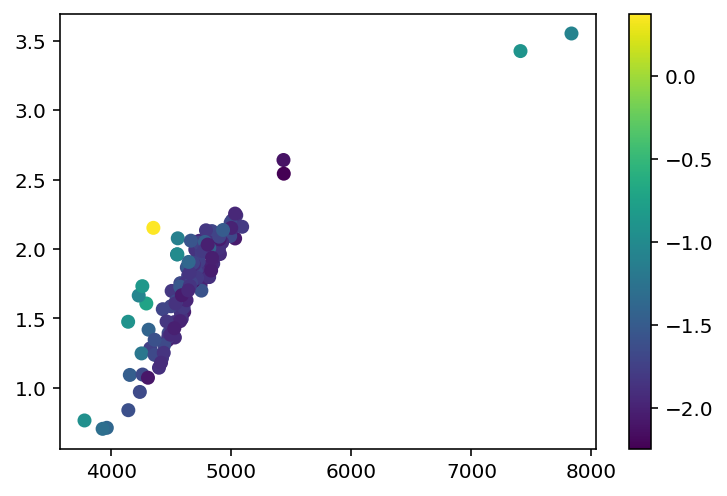

In [26]:
s = plt.scatter(
    final_table_plxcom['teff'],
    final_table_plxcom['logg'],
    c = final_table_plxcom['fe_h']
)
plt.colorbar(s)

In [28]:
final_table_plxcom[final_table_plxcom['sobject_id']==140305003201024]

sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,best_spec4star,flag_sp,flag_sp_fit,opt_loop,flag_red,snr_px_ccd1,snr_px_ccd2,snr_px_ccd3,snr_px_ccd4,chi2_sp,px_used_perc,model_name,closest_model,comp_time,flux_contr,e_flux_contr,fit_global_rv,rv_comp_nr,rv_comp_1,e_rv_comp_1,rv_comp_1_h,rv_comp_1_p,rv_comp_2,e_rv_comp_2,rv_comp_2_h,rv_comp_2_p,rv_gaia_dr3,e_rv_gaia_dr3,v_bary_eff,teff,e_teff,logg,e_logg,fe_h,e_fe_h,flag_fe_h,vmic,e_vmic,vsini,e_vsini,teff_comp_2,e_teff_comp_2,logg_comp_2,e_logg_comp_2,fe_h_comp_2,e_fe_h_comp_2,flag_fe_h_comp_2,vmic_comp_2,e_vmic_comp_2,vsini_comp_2,e_vsini_comp_2,li_fe,e_li_fe,flag_li_fe,c_fe,e_c_fe,flag_c_fe,n_fe,e_n_fe,flag_n_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,rb_fe,e_rb_fe,flag_rb_fe,sr_fe,e_sr_fe,flag_sr_fe,y_fe,e_y_fe,flag_y_fe,zr_fe,e_zr_fe,flag_zr_fe,mo_fe,e_mo_fe,flag_mo_fe,ru_fe,e_ru_fe,flag_ru_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,ce_fe,e_ce_fe,flag_ce_fe,nd_fe,e_nd_fe,flag_nd_fe,sm_fe,e_sm_fe,flag_sm_fe,eu_fe,e_eu_fe,flag_eu_fe,mass,age,bc_ks,a_ks,lbol,r_med,r_lo,r_hi,sb2_rv_16,sb2_rv_50,sb2_rv_84,ew_h_beta,ew_h_alpha,ew_k_is,sigma_k_is,rv_k_is,ew_dib5780,sigma_dib5780,rv_dib5780,ew_dib5797,sigma_dib5797,rv_dib5797,ew_dib6613,sigma_dib6613,rv_dib6613
int64,str16,int64,str17,int32,str6,float32,float64,float64,bool,int32,int32,int32,int32,float32,float32,float32,float32,float32,int64,str16,str16,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
140305003201024,13275252-4733174,6083515033827932800,NGC_5139_oCen,-6,plxcom,56721.7,201.9688720703125,-47.55486297607422,False,0,0,2,32768,23.398088,37.547024,53.377277,46.39765,0.64272934,94,5000_2.00_-2.00,5000_2.00_-2.00,55.20797,1.0,nan,True,1.0,248.48216,0.044399448,nan,nan,nan,nan,nan,nan,nan,nan,20.322874069213867,5032.516,15.167238,2.0754461,nan,-2.0606332,0.03106113,1,1.0897545,0.102260835,8.996133,0.46819082,nan,nan,nan,nan,nan,nan,-1,nan,nan,nan,nan,1.0215094,0.23008513,1,nan,0.622366,17,nan,nan,2,nan,nan,2,0.4743533,0.084736206,1,0.43049425,0.082746,1,nan,nan,2,0.3543798,0.090116516,1,0.4174369,0.06859769,0,0.3012679,0.04931845,0,0.11484593,0.10631741,1,0.27486968,0.068822205,0,-0.88400006,0.40310064,1,-0.198753,0.12736651,1,-0.048628088,0.04553269,1,0.5525444,0.06690885,1,-0.11543211,0.04252074,1,-0.5288698,0.3098814,1,0.13046905,0.15574533,1,nan,nan,2,nan,nan,2,-0.20782578,0.11147108,1,nan,nan,2,nan,nan,2,nan,nan,2,0.6705666,0.10668609,0,0.2436924,0.14193223,1,nan,nan,2,0.15763517,0.091771625,1,nan,nan,2,nan,nan,2,1.0232131,5.87

In [27]:
# sobject_id = 220518002401217
# setup = 'plxcom'

# results = Table.read('../analysis_products/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_'+setup+'_fit_results.fits')
# results